In [1]:
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
modelname = 'resnet50'
model_dir = os.path.join(emb_path,modelname)

In [4]:
manifolds_load = np.load(os.path.join(model_dir,'manifolds.npy'),allow_pickle=True)

In [5]:
from jax import numpy as np
from jax import jit, random
key = random.PRNGKey(0)

In [6]:
P = 500
manifolds = []
for manifold in manifolds_load[:100]:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [8]:
K = manifolds.shape[0]

def fewshot_experiment_jax(key,X,k,m):
    Xtrain = []
    Xtest = []
    for x in X:
        perm = random.permutation(key,P)
        xtrain,xtest = np.split(x[perm],(m,))
        Xtrain.append(xtrain)
        Xtest.append(xtest)
    Xtrain = np.stack(Xtrain)
    Xtest = np.stack(Xtest)

    prototypes = Xtrain.mean(1)
    dists = ((prototypes[:,None,None] - Xtest[None])**2).sum(-1)
    preds = dists.argmin(0)
    targets = np.tile(np.arange(k)[:,None],(P-m,))
    errs = (preds!=targets).mean(-1)
    
    return errs

fewshot_experiment_jit = jit(fewshot_experiment_jax,static_argnums=(2,3))

In [72]:
def fewshot_experiment_fast(key,X,k,m,navg):
    ''' Performs a quick heuristic m-shot learning experiment on a pair of manifolds X=(Xa,Xb),
    allowing overlap between training and test examples.
    
    Args: 
        X: (k,P,N)
    
    Returns:
        errs: (k,) avg error on each manifold
    '''
    prototypes = []
    for a in range(k):
        key,_ = random.split(key)
        idxs = random.randint(key, (m,navg), 0,P)
        prototypes.append(X[a][idxs].mean(0))
    prototypes = np.stack(prototypes)

    dists = ((prototypes[:,None,:,None] - X[None,:,None])**2).sum(-1)
    preds = dists.argmin(0).reshape(k,-1)
    targets = np.tile(np.arange(k)[:,None],(P*navg,))
    errs = (preds!=targets)
    err_mean = errs.mean(-1)
    err_std = errs.std(-1)

    return err_mean,err_std

fewshot_experiment_fast = jit(fewshot_experiment_fast, static_argnums=(2,3,4))

In [50]:
%%timeit
fewshot_experiment_fast(key,X,k,m,100)

46.9 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
ks = np.arange(2,50,5) 
m = 5
navg = 100
ms = np.arange(1,6)
errs_all = {}
for k in tqdm(ks):
    errs_all[k] = []
    key,_ = random.split(key)
    idxs = random.randint(key,(k,),0,K)
    X = manifolds[idxs]
    errs = fewshot_experiment_fast(key,X,k,m,navg)
    errs_all[k].append(errs)
# errs_all = np.stack(errs_all).reshape(len(ms),-1,k)

100%|██████████| 10/10 [02:40<00:00, 16.06s/it]


In [52]:
err_means = []
for k in ks:
    err_means.append(np.mean(np.stack(errs_all[k])))
err_means = np.stack(err_means)

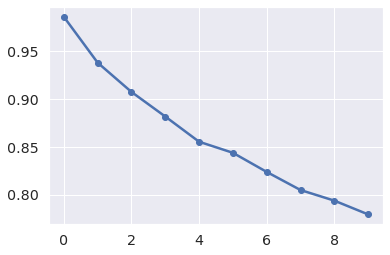

In [76]:
plt.plot(1-err_means, 'o-')

# Theory

In [54]:
from scipy.special import erfc
def H(x):
    return erfc(x/np.sqrt(2))/2

In [55]:
Rs = np.load(os.path.join(model_dir,'Rs.npy'))
Ds = (Rs**2).sum(-1)**2 / (Rs**4).sum(-1)
Us = np.load(os.path.join(model_dir,'Us.npy'))
x0s = np.load(os.path.join(model_dir,'centers.npy'))

In [56]:
from scipy.spatial.distance import pdist, squareform
dists = squareform(pdist(x0s))
dist_norm = dists / np.sqrt((Rs**2).mean(-1)[:,None])

In [57]:
# csa_all = np.load(os.path.join(model_dir,'center_subspace_a.npy'))
# csb_all = np.load(os.path.join(model_dir,'center_subspace_b.npy'))
# ss_all = np.load(os.path.join(model_dir,'subspace_subspace.npy'))

In [137]:
from scipy.stats import mvn

def kway_theory(idxs,m,k):
    pred_errs = []
    for a in idxs:
        Sigma = []
        mu = []
        for b in idxs[idxs!=a]:
            for c in idxs[idxs!=a]:
                dx0b = x0s[a] - x0s[b]
                dx0c = x0s[a] - x0s[c]
                csa = (Rs[a]**2*(Us[a]@dx0b)*(Us[a]@dx0c)).mean() / (Rs[a]**2).mean()**2

                sigma = 1/Ds[a]/m + 1/(2*Ds[a]*m**2) + csa

                if b==c:
                    sigma += (Rs[b]**2).mean()/(Rs[a]**2).mean()/(2*Ds[b]*m**2)
                    csb = ((Rs[b]*(Us[b]@dx0b))**2).mean() / (Rs[a]**2).mean()**2 / m
                    sigma += csb
                    cosphi = Us[a]@Us[b].T
                    ss = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2 / m
                    sigma += ss

                    mean = 1/2*((x0s[a] - x0s[b])**2).sum() / (Rs[a]**2).mean()
                    mean += 1/2*((Rs[b]**2).sum()/(Rs[a]**2).sum() - 1)/m
                    mu.append(mean)
                Sigma.append(sigma)
        Sigma = np.stack(Sigma).reshape(k-1,k-1)
        mu = np.stack(mu)

        pred_err = 1 - mvn.mvnun(np.zeros(k-1), np.ones(k-1)*1e10,mu,Sigma)[0]
        pred_errs.append(pred_err)

    return np.stack(pred_errs)

In [78]:
k = 3
m = 5
ntest = 50
navg = 1000
ms = np.arange(1,6)
errs_mean = []
errs_std = []
pred_errs_all = []
for _ in tqdm(range(ntest)):
    key,_ = random.split(key)
    idxs = random.choice(key,K,(k,),replace=False)
    pred_errs = kway_theory(idxs,m,k)
    pred_errs_all.append(pred_errs)
    X = manifolds[idxs]
    key,_ = random.split(key)
    err,err_std = fewshot_experiment_fast(key,X,k,m,navg)
    errs_mean.append(err)
    errs_std.append(err_std)
    
errs_mean = np.stack(errs_mean)
errs_std = np.stack(errs_std)
pred_errs_all = np.stack(pred_errs_all)

100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


In [79]:
from scipy.special import erfc, erfcinv
def H(x):
    return erfc(x/np.sqrt(2))/2

def Hinv(z):
    return erfcinv(2*z)*np.sqrt(2)

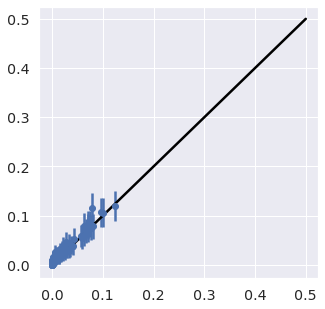

In [82]:
plt.figure(figsize=(5,5))
plt.errorbar(pred_errs_all.ravel(),errs_mean.ravel(),errs_std.ravel()/np.sqrt(navg)*3,fmt='o')

plt.plot([0,0.5],[0,0.5], c='black')

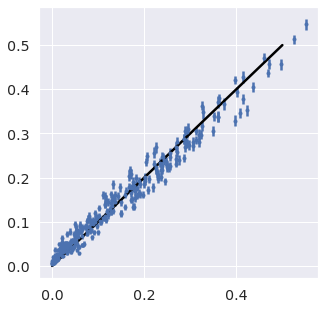

In [21]:
plt.figure(figsize=(5,5))

plt.errorbar(pred_errs_all.ravel(),err_means.ravel(),err_stds.ravel()/np.sqrt(navg)*3,fmt='.')

plt.plot([0,0.5],[0,0.5], c='black')

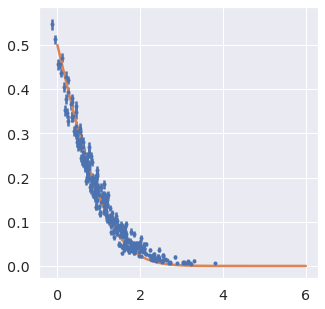

In [20]:
plt.figure(figsize=(5,5))

plt.errorbar(Hinv(pred_errs_all.ravel()),err_means.ravel(),err_stds.ravel()/np.sqrt(navg)*3,fmt='.')

# plt.plot([0,0.5],[0,0.5], c='black')
xx = np.linspace(0,6,1000)
plt.plot(xx,H(xx))

## Scaling

In [125]:
k = 50
idxs = np.arange(k)
X = manifolds[idxs]
errs,errs_std = fewshot_experiment_fast(key,X,k,m,navg)

In [225]:
np.arange(2,54,4)

DeviceArray([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50], dtype=int32)

In [227]:
ks = np.arange(2,54,4)
m = 5
ntest = 5000
navg = 100
ms = np.arange(1,11)
errs_all = []
pred_errs_all = []
idxs_all = []
err_means = []
err_stds = []
err_pred_means = []
for k in ks:
    errs_all = []
    pred_errs_all = []
    for _ in tqdm(range(ntest//k)):
        key,_ = random.split(key)
        idxs = random.choice(key,K,(k,),replace=False)
        idxs_all.append(idxs)
        pred_errs = kway_theory(idxs,m,k)
        pred_errs_all.append(pred_errs)
        X = manifolds[idxs]

        key,_ = random.split(key)
        errs,errs_std = fewshot_experiment_fast(key,X,k,m,navg)
        errs_all.append(errs)
            
    errs_all = np.stack(errs_all)
    err_means.append(errs_all.mean())
    err_stds.append(errs_all.std())
    err_pred_means.append(np.nanmean(np.stack(pred_errs_all)))

err_means = np.stack(err_means)
err_stds = np.stack(err_stds)
err_pred_means = np.stack(err_pred_means)

100%|██████████| 100/100 [2:52:22<00:00, 103.43s/it] 


In [238]:
from scipy import stats

def plot_CI(x,y,c,fmt,alpha=1):
    plt.plot(x,y.mean(-1), fmt, c=c,alpha=alpha)
    CImin,CImax = stats.t.interval(0.95, len(y),
                     loc=y.mean(-1), scale=stats.sem(y,axis=-1))
    plt.fill_between(x,CImin,CImax,color=c, alpha=0.2)

In [243]:
CImin,CImax = stats.t.interval(0.99, ntest, loc=err_means, scale=err_stds/np.sqrt(ntest))

In [244]:
sns.set_style('whitegrid')

In [265]:
np.savez('data/kway_errs.npz',ks=ks,err_means=err_means,err_stds=err_stds)

/home/bsorsch/.jax/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2 6 10 14 18 22 26 30 34 38 42 46 50] in fill_betweenx(). This will become an error two minor releases later.
  """


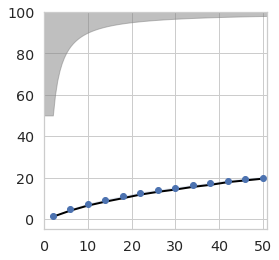

In [250]:
plt.figure(figsize=(4,4))
plt.plot(ks,100*err_pred_means,c='black', linewidth=2)
plt.plot(ks,100*err_means, 'o')
# plt.fill_between(ks,100*(err_means+err_stds),100*(err_means-err_stds),alpha=0.5)
plt.fill_between(ks,100*CImin,100*CImax, 'o-',alpha=0.2)



t = np.linspace(2,np.max(ks)+2,100)
xx = np.concatenate([np.zeros(1),t])
yy = np.concatenate([np.ones(1)*0.5,1-1/t])
plt.fill_between(xx,100*yy, 100*np.ones(len(t)+1), color='gray', alpha=0.5)
# plt.xlim([np.min(ks), np.max(ks)])
plt.ylim([-5,100]);
plt.xlim([0,51])
plt.xticks([0,10,20,30,40,50]);
plt.savefig('images/k_way_theory_experiment.pdf')

(0.0, 50.0)

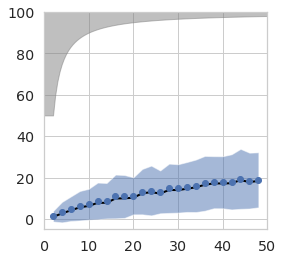

In [224]:
plt.figure(figsize=(4,4))
plt.plot(ks,100*err_pred_means,c='black', linewidth=2)
plt.plot(ks,100*err_means, 'o')
plt.fill_between(ks,100*CImin,100*CImax, 'o-',alpha=0.2)



t = np.linspace(2,np.max(ks)+2,100)
xx = np.concatenate([np.zeros(1),t])
yy = np.concatenate([np.ones(1)*0.5,1-1/t])
plt.fill_between(xx,100*yy, 100*np.ones(len(t)+1), color='gray', alpha=0.5)
# plt.xlim([np.min(ks), np.max(ks)])
plt.ylim([-5,100]);
plt.xlim([0,50])
# plt.savefig('images/k_way_theory_experiment.pdf')

/home/bsorsch/.jax/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2 3 4 5 6 7 8 9] in fill_betweenx(). This will become an error two minor releases later.
  


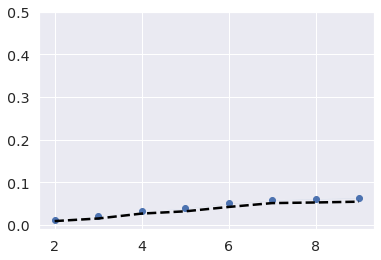

In [105]:
plt.plot(ks,err_means, 'o')
plt.fill_between(ks,CImin,CImax, 'o-',alpha=0.2)
plt.plot(ks,err_pred_means,c='black',linestyle='dashed')
plt.ylim([-0.01,0.5]);

/home/bsorsch/.jax/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2 3 4 5 6 7 8 9] in fill_betweenx(). This will become an error two minor releases later.
  


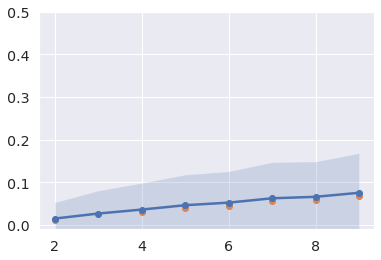

In [72]:
plt.plot(ks,err_means, 'o-')
plt.fill_between(ks,err_means+err_stds,err_means-err_stds, 'o-',alpha=0.2)
plt.plot(ks,err_pred_means)
plt.ylim([-0.01,0.5]);